In [1]:
from gensim.models import KeyedVectors
from gensim.test import test_data
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
questions_en = '/home/levai/.miniconda3/envs/gensim/lib/python3.8/site-packages/gensim/test/test_data/questions-words.txt'

In [3]:
questions = '/mnt/permanent/Language/Hungarian/Embed/questions-words-hu/questions-words-hu.txt'

In [4]:
vectors_en = KeyedVectors.load('/mnt/permanent/Language/English/Embed/glove.840B.300d.gensim')

In [5]:
vectors = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/mnsz2/glf/mnsz-glf-sgram-600.gensim')

In [6]:
embed_dir = '/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0'

In [7]:
def get_accuracies(vectors, questions):
    score, sections = vectors.evaluate_word_analogies(questions)
    #print(score)
    df_ = pd.DataFrame(sections)
    df_.set_index('section', inplace=True)
    df = df_.apply({'correct': len, 'incorrect': len})
    df['total'] = df.sum(axis=1)
    df['accuracy'] = df.correct / df.total
    df.drop(index=['Total accuracy'], inplace=True)
    return df

# English

In [9]:
df_en = get_accuracies(vectors_en, questions_en)

0.7682115764314663


In [10]:
df = get_accuracies(vectors, questions)

0.19274598701139567


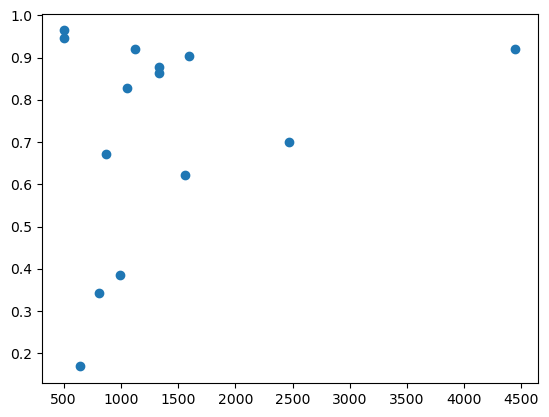

In [11]:
plt.scatter(df_en.total, df_en.accuracy)

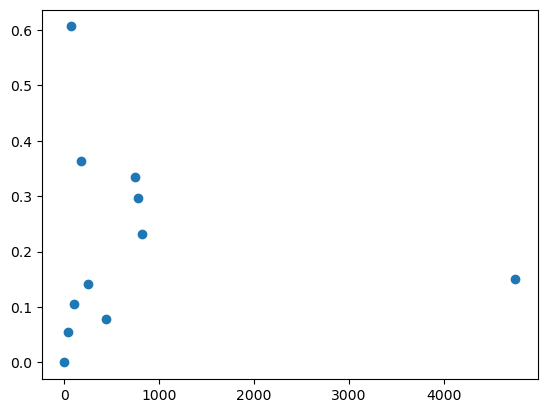

In [12]:
plt.scatter(df.total, df.accuracy)

# Webcorpus 2.0: gluten-free and vanila

In [35]:
def mean_semantic_accurcy(model):
    df = get_accuracies(model.wv, questions)
    return df[~df.index.str.startswith('gram')].accuracy.mean()

In [36]:
def get_accuracy_by_size():
    for file_pattern in ['2017_2018_2956', '2017_2018_295', '2017_2018_29', '2017_2018_2', '2017_2018', '201', '']:
        for deglutinate_ in ['vanila', 'deglut']:
            try:
                model = KeyedVectors.load(f'{embed_dir}/sgns-300-{file_pattern}-{deglutinate_}.gensim')
            except FileNotFoundError:
                break
            record = ({
                'files': f'{file_pattern}*',
                'deglut' : deglutinate_,
                'sentence': model.corpus_count, 
                'token': model.corpus_total_words, 
                'type': len(model.wv.key_to_index),
                'accuracy': mean_semantic_accurcy(model)})#f'{:.0%}'
            print(record)
            yield record

In [37]:
records = get_accuracy_by_size()

In [38]:
df_ = pd.DataFrame(records)

{'files': '2017_2018_2956*', 'deglut': 'vanila', 'sentence': 66798, 'token': 894741, 'type': 9388, 'accuracy': 0.0}
{'files': '2017_2018_2956*', 'deglut': 'deglut', 'sentence': 66798, 'token': 1192818, 'type': 6739, 'accuracy': 0.06666666666666667}
{'files': '2017_2018_295*', 'deglut': 'vanila', 'sentence': 879317, 'token': 16948301, 'type': 149981, 'accuracy': 0.02938912938912939}
{'files': '2017_2018_295*', 'deglut': 'deglut', 'sentence': 879317, 'token': 22585465, 'type': 77302, 'accuracy': 0.03741929094870271}
{'files': '2017_2018_29*', 'deglut': 'vanila', 'sentence': 12058626, 'token': 228013641, 'type': 1028343, 'accuracy': 0.08137027271617372}
{'files': '2017_2018_29*', 'deglut': 'deglut', 'sentence': 12058626, 'token': 228013669, 'type': 987379, 'accuracy': 0.09646544159516732}
{'files': '2017_2018_2*', 'deglut': 'vanila', 'sentence': 133832368, 'token': 2485943840, 'type': 4730753, 'accuracy': 0.29344167530628085}
{'files': '2017_2018_2*', 'deglut': 'deglut', 'sentence': 13383

In [39]:
df_

,files,deglut,sentence,token,type,accuracy
0,2017_2018_2956*,vanila,66798,894741,9388,0.000000
1,2017_2018_2956*,deglut,66798,1192818,6739,0.066667
2,2017_2018_295*,vanila,879317,16948301,149981,0.029389
3,2017_2018_295*,deglut,879317,22585465,77302,0.037419
4,2017_2018_29*,vanila,12058626,228013641,1028343,0.081370
5,2017_2018_29*,deglut,12058626,228013669,987379,0.096465
6,2017_2018_2*,vanila,133832368,2485943840,4730753,0.293442
7,2017_2018_2*,deglut,133832368,2485946156,4513971,0.298626
8,2017_2018*,vanila,511812157,9640537495,11400728,0.426957


In [40]:
df = df_.drop(columns=['deglut', 'accuracy']).groupby('files').max()
df = df.join(pd.pivot_table(df_, values='accuracy', index='files', columns='deglut'), rsuffix='_')
df.sort_values('sentence', inplace=True)

In [41]:
df

,sentence,token,type,deglut,vanila
files,,,,,
2017_2018_2956*,66798,1192818,9388,0.066667,0.000000
2017_2018_295*,879317,22585465,149981,0.037419,0.029389
2017_2018_29*,12058626,228013669,1028343,0.096465,0.081370
2017_2018_2*,133832368,2485946156,4730753,0.298626,0.293442
2017_2018*,511812157,9640537495,11400728,NaN,0.426957


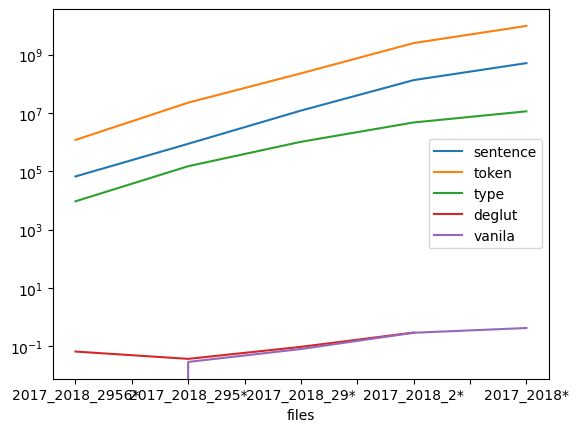

In [42]:
df.plot()
plt.yscale('log')

<Axes: xlabel='files'>

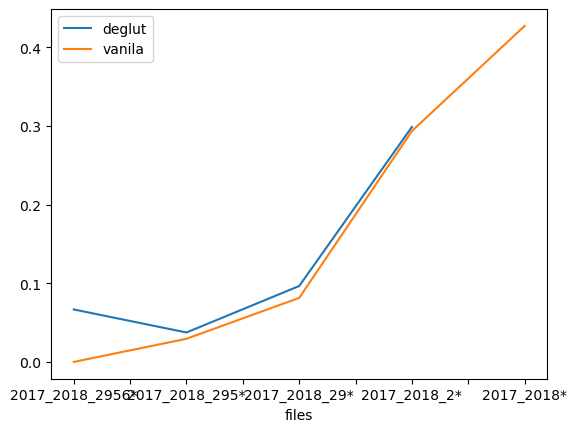

In [43]:
df[['deglut', 'vanila']].plot()


# Error analysis in the best model

In [59]:
vectors = KeyedVectors.load(
    '/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018_2-vanila.gensim').wv

In [60]:
%time get_accuracies(vectors, questions)#, dummy4unknown=True)

CPU times: user 17min 53s, sys: 9.6 s, total: 18min 3s
Wall time: 1min 32s


,correct,incorrect,total,accuracy
section,,,,
capital-common-countries,66,124,190,0.347368
capital-world,720,2440,3160,0.227848
county-ceter,38,133,171,0.222222
currency,54,352,406,0.133005
family,73,63,136,0.536765
gram1-adjective-to-adverb,153,627,780,0.196154
gram2-opposite,66,369,435,0.151724
gram3-comparative,476,304,780,0.610256
gram4-superlative,364,416,780,0.466667
